In [44]:
#Install Packages
!pip install lime
!pip install plotly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
import os
import numpy as np
import pandas as pd
import plotly
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import plotly.express as px
import re
import nltk
from nltk.util import ngrams
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score,confusion_matrix,roc_curve, auc, classification_report
import lime
from lime import lime_text
from lime.lime_text import LimeTextExplainer

In [46]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,7)
plt.style.use('fivethirtyeight')
sns.set_theme(style="darkgrid")
# pd.set_option("display.max_colwidth", None)

In [47]:
# setting defaut path of the entire project directory
os.chdir("/content/drive/MyDrive/Neurotech/Swahili Social Media Sentiment Analysis with results interpretability")

In [48]:
# loading datasets
df = pd.read_csv("data/swahili-social-sentiments.csv")

In [49]:
print(f"Dataframe file structure is: {df.shape}")

Dataframe file structure is: (2263, 3)


In [50]:
df.head()

,ID,Tweets,Labels
0,2,So chuga si tunakutana kesho kwenye Nyamachoma...,0
1,3,Asante sana watu wa Sirari jimbo la Tarime ...,1
2,5,Leo nimepata kitambulisho changu cha taifa ...,1
3,6,Mgema akisifiwa tembo hulitia maji,0
4,8,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuaf...,1


*Label (1:positive, -1: negative, 0: neutral).*


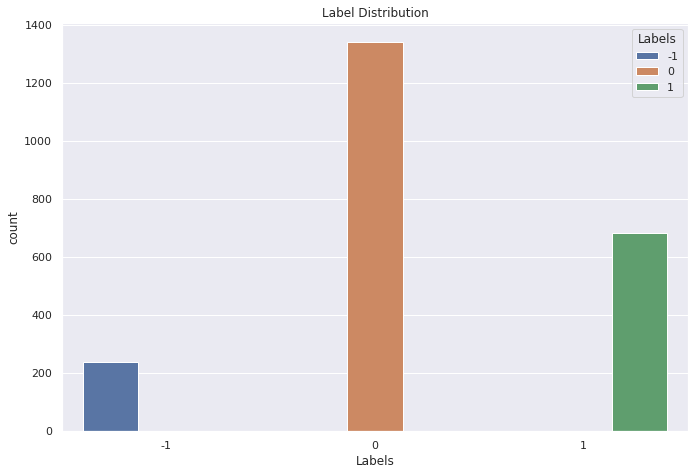

In [51]:
# Label (1:positive, -1: negative, 0: neutral).
plt.figure(figsize=(10,7))
sns.countplot(x="Labels", hue="Labels", data=df)
plt.title("Label Distribution")
plt.savefig('images/class-dist.png');

### Preprocessing

- Cleaning text
  - Converting to lower case
  - Removing non alphanumeric text
  - Removing Stopwords
  - Tokenizes the text 

In [52]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [53]:
stw = pd.read_csv("data/Common Swahili Stop-words.csv")
stw.head()

,StopWords
0,na
1,lakini
2,ingawa
3,ingawaje
4,kwa


In [54]:
swstopwords = set(stw["StopWords"])

In [55]:
def clean_tweets(tweet):
    '''
        function to clean content column, make it ready for transformation and modeling
    '''
    tweet = tweet.lower() #convert text to lower-case
    tweet = re.sub('[‘’“”…,]', '', tweet) # remove punctuation
    tweet = re.sub('[()]', '', tweet) # remove parenthesis
    tweet = re.sub("[^a-zA-Z]"," ",tweet) #remove numbers and keep text/alphabet only
    tweet_list = nltk.word_tokenize(tweet)
    clean_tweets=[i for i in tweet_list if i not in swstopwords] # remove stop words
    return ' '.join(clean_tweets)

In [56]:
df['clean_tweets'] = df['Tweets'].apply(clean_tweets)
df['clean_tweets'].head()

0    so chuga tunakutana kesho nyamachoma festival ...
1    asante watu sirari jimbo tarime vijijini upend...
2        leo nimepata kitambulisho changu taifa asante
3                   mgema akisifiwa tembo hulitia maji
4    ee mwenyezi mungu msamehe umrehemu umuafu msam...
Name: clean_tweets, dtype: object

In [57]:
df.head()

,ID,Tweets,Labels,clean_tweets
0,2,So chuga si tunakutana kesho kwenye Nyamachoma...,0,so chuga tunakutana kesho nyamachoma festival ...
1,3,Asante sana watu wa Sirari jimbo la Tarime ...,1,asante watu sirari jimbo tarime vijijini upend...
2,5,Leo nimepata kitambulisho changu cha taifa ...,1,leo nimepata kitambulisho changu taifa asante
3,6,Mgema akisifiwa tembo hulitia maji,0,mgema akisifiwa tembo hulitia maji
4,8,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuaf...,1,ee mwenyezi mungu msamehe umrehemu umuafu msam...


In [58]:
df.isna().sum().any()

False

### Sentiment Analysis

In [59]:
from textblob import TextBlob

In [60]:
def polarity_score(tweet):
  '''
        This function takes in a tweet data and returns the polarity of the tweet 
        Polarity is float which lies in the range of [-1,0,1] where 1 means positive statement, 0 means positive statement 
        and -1 means a negative statement
    '''
  return TextBlob(tweet).sentiment.polarity

In [61]:

def subjectivity_score(tweet):
  '''
      This function takes in a text data and returns the subectivity of the text. 
      Subjectivity sentences generally refer to personal opinion, 
      emotion or judgment whereas objective refers to factual information. 
      Subjectivity is also a float which lies in the range of [0,1].
  '''
  return TextBlob(tweet).sentiment.subjectivity

In [62]:
#apply above functions to the data
df['polarity_score']=df['clean_tweets'].apply(polarity_score) 
df['subjectivity_score']=df['clean_tweets'].apply(subjectivity_score)

In [63]:
df.head()

,ID,Tweets,Labels,clean_tweets,polarity_score,subjectivity_score
0,2,So chuga si tunakutana kesho kwenye Nyamachoma...,0,so chuga tunakutana kesho nyamachoma festival ...,0.0,0.0
1,3,Asante sana watu wa Sirari jimbo la Tarime ...,1,asante watu sirari jimbo tarime vijijini upend...,0.0,0.0
2,5,Leo nimepata kitambulisho changu cha taifa ...,1,leo nimepata kitambulisho changu taifa asante,0.0,0.0
3,6,Mgema akisifiwa tembo hulitia maji,0,mgema akisifiwa tembo hulitia maji,0.0,0.0
4,8,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuaf...,1,ee mwenyezi mungu msamehe umrehemu umuafu msam...,0.0,0.0


In [64]:
df.polarity_score.value_counts().sample(10)

-0.250000     1
 0.200000     6
-0.033333     1
-0.500000     1
 0.333333     4
 0.300000     5
 0.136364    12
-0.133333     1
-0.400000     1
 0.318182     3
Name: polarity_score, dtype: int64

In [65]:
df.subjectivity_score.value_counts().sample(10)

0.833333       2
0.750000       2
0.408333       1
0.300000       8
1.000000      11
0.666667       4
0.000000    2126
0.577273       1
0.541667       1
0.450000       1
Name: subjectivity_score, dtype: int64

In [66]:
print(' The overall polarity of the tweet data is '+ str(round(df['polarity_score'].mean(),2)))
print(' The overall subjectivity of the tweet data is '+ str(round(df['subjectivity_score'].mean(),2)))

 The overall polarity of the tweet data is 0.01
 The overall subjectivity of the tweet data is 0.03


In [67]:
sub_df = df[['Labels','polarity_score','subjectivity_score']]
sub_df.groupby('Labels').mean()

,polarity_score,subjectivity_score
Labels,,
-1,-0.002637,0.027495
0,0.012994,0.034260
1,0.014817,0.025858


In [69]:
#Histogram Plot For Overall Polarity Distribution

fig = px.histogram(
    df,
    x = "polarity_score",
    title = "Overall Polaritry Score Distribution"
)
fig.show(renderer="colab")

In [70]:
#Histogram Plot For Overall subjectivity Distribution

fig = px.histogram(
    df,
    x = "subjectivity_score",
    title = "Overall Subjectivity Score Distribution"
)
fig.show(renderer="colab")
plt.savefig('images/subjectivity-score-distribution.png');

<Figure size 864x504 with 0 Axes>

In [71]:
# visualization
fig = make_subplots(rows=3, cols=2,subplot_titles=("Polarity Score Distribution-Negative", "Subjectivity Score Distribution-Negative",
                                                   "Polarity Score Distribution-Neutral", "Subjectivity Score Distribution-Neutral",
                                                   'Polarity Score Distribution-Positive','Subjectivity Score Distribution-Positive'),
                    x_title="Score",y_title='Frequency')
fig.add_trace(
    go.Histogram(x=df[df['Labels']== -1 ]['polarity_score']),
    row=1, col=1)
fig.add_trace(
    go.Histogram(x=df[df['Labels']== -1 ]['subjectivity_score']),
    row=1, col=2)
fig.add_trace(
    go.Histogram(x=df[df['Labels']== 0 ]['polarity_score']),
    row=2, col=1)
fig.add_trace(
    go.Histogram(x=df[df['Labels']== 0 ]['subjectivity_score']),
    row=2, col=2)
fig.add_trace(
    go.Histogram(x=df[df['Labels']== 1]['polarity_score']),
    row=3, col=1)
fig.add_trace(
    go.Histogram(x=df[df['Labels']== 1]['subjectivity_score']),
    row=3, col=2)
fig.show(renderer="colab")

In [72]:
# Tweet outliers
print('Tweet with the higest polarity:',(df[df['polarity_score']==df['polarity_score'].max()]['Tweets'].iloc[0]),'Label of tweet with highest polarity:',df[df['polarity_score']==df['polarity_score'].max()]['Labels'].iloc[0],sep="\n")

print('Tweet with the lowest polarity:',(df[df['polarity_score']==df['polarity_score'].min()]['Tweets'].iloc[0]),'Label of tweet with lowest polarity:',df[df['polarity_score']==df['polarity_score'].min()]['Labels'].iloc[0],sep="\n")

print('Tweet with the higest subjectivity:',(df[df['subjectivity_score']==df['subjectivity_score'].max()]['Tweets'].iloc[0]),'Label of tweet with highest subjectivity:',df[df['subjectivity_score']==df['subjectivity_score'].max()]['Labels'].iloc[0],sep="\n")

print('Tweet with the lowest subjectivity:',(df[df['subjectivity_score']==df['subjectivity_score'].min()]['Tweets'].iloc[0]),'Label of tweet with lowest subjectivity:',df[df['subjectivity_score']==df['subjectivity_score'].min()]['Labels'].iloc[0],sep="\n")


Tweet with the higest polarity:
   iyo nawakilisha ni best colabo of all time kwa upande wangu Haijawahi tokea tena
Label of tweet with highest polarity:
1
Tweet with the lowest polarity:
Nipende sana kumshukuru wameongea mengi sanasana Mm ss hv nimeamua kuwekeza nguvu zangu nyingi sana nipate followers Nilipost kuomba volunteerintership nikamtag mtu ata hili kureetweeti was so sad
Label of tweet with lowest polarity:
1
Tweet with the higest subjectivity:
Ni kweli You areca beautiful Woman sijui Girl hongera
Label of tweet with highest subjectivity:
1
Tweet with the lowest subjectivity:
So chuga si tunakutana kesho kwenye Nyamachoma festival nanenanemnajifanyaga mnakula mtungi mje kesho niwakalishe
Label of tweet with lowest subjectivity:
0


## Word Frequency

In [73]:
# Before that, we tokenize the text data using the with space between them
def tokenize_text(tweet):
    return tweet.split()
df['tokenized_tweet']=df.clean_tweets.apply(tokenize_text)
df.head()

,ID,Tweets,Labels,clean_tweets,polarity_score,subjectivity_score,tokenized_tweet
0,2,So chuga si tunakutana kesho kwenye Nyamachoma...,0,so chuga tunakutana kesho nyamachoma festival ...,0.0,0.0,"[so, chuga, tunakutana, kesho, nyamachoma, fes..."
1,3,Asante sana watu wa Sirari jimbo la Tarime ...,1,asante watu sirari jimbo tarime vijijini upend...,0.0,0.0,"[asante, watu, sirari, jimbo, tarime, vijijini..."
2,5,Leo nimepata kitambulisho changu cha taifa ...,1,leo nimepata kitambulisho changu taifa asante,0.0,0.0,"[leo, nimepata, kitambulisho, changu, taifa, a..."
3,6,Mgema akisifiwa tembo hulitia maji,0,mgema akisifiwa tembo hulitia maji,0.0,0.0,"[mgema, akisifiwa, tembo, hulitia, maji]"
4,8,Ee Mwenyezi Mungu Msamehe na Umrehemu na Umuaf...,1,ee mwenyezi mungu msamehe umrehemu umuafu msam...,0.0,0.0,"[ee, mwenyezi, mungu, msamehe, umrehemu, umuaf..."


In [74]:
word_freq=pd.DataFrame(df['clean_tweets'].str.split(expand=True).stack().value_counts()).reset_index()
word_freq=word_freq.rename(columns={'index':'Word', 0:'Count'})
fig = px.bar(df, x=word_freq['Word'][0:20], y=word_freq['Count'][0:20])
fig.update_layout(xaxis_title="Word", yaxis_title="Count", title="Top 20 most Frequent words in across entire tweet data")
fig.show(renderer="colab")

The most used words are `habari`,`leo`, `siku`, `namba` , `watu` etc

#### Most used words per Label

In [75]:
# Negative Tweets Word Frequency
word_freq_neg=pd.DataFrame(df[df['Labels']== -1]['clean_tweets'].str.split(expand=True).stack().value_counts()).reset_index()
word_freq_neg=word_freq_neg.rename(columns={'index':'Word',0:'Count'})

# Neutral Tweets Word Frequency
word_freq_neut=pd.DataFrame(df[df['Labels']== 0]['clean_tweets'].str.split(expand=True).stack().value_counts()).reset_index()
word_freq_neut=word_freq_neut.rename(columns={'index':'Word',0:'Count'})

# Positive Tweets Word Frequency
word_freq_pos=pd.DataFrame(df[df['Labels']== 1]['clean_tweets'].str.split(expand=True).stack().value_counts()).reset_index()
word_freq_pos=word_freq_pos.rename(columns={'index':'Word',0:'Count'})

fig = make_subplots(rows=1, cols=3,subplot_titles=("Top 20 most frequent words-Negative", "Top 20 most frequent words-Neutral", "Top 20 most frequent words-Positive"),
                    x_title="Word",y_title='Count')
fig.add_trace(
    go.Bar(x=word_freq_neg['Word'].iloc[0:20], y=word_freq_neg['Count'].iloc[0:20]),
    row=1, col=1
    )
fig.add_trace(
    go.Bar(x=word_freq_neut['Word'].iloc[0:20], y=word_freq_neut['Count'].iloc[0:20]),
    row=1, col=2
    )
fig.add_trace(
    go.Bar(x=word_freq_pos['Word'].iloc[0:20], y=word_freq_pos['Count'].iloc[0:20]),
    row=1, col=3
    )
fig.show(renderer="colab")

### Modelling

In [76]:
# data split
X = df["clean_tweets"]
y = df["Labels"]

seed = 42

x_train,x_test,y_train,y_test= train_test_split(X,y,stratify=y, test_size=0.2, random_state=seed)

In [77]:
# instantiating model pipeline
model = make_pipeline(
    TfidfVectorizer(),
    LogisticRegression()
)

# training model
model.fit(x_train,y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer()),
                ('logisticregression', LogisticRegression())])

In [78]:
# evaluation on train set
model.score(x_train,y_train)

0.8215469613259668

In [79]:
# evaluation on test set
model.score(x_test,y_test)

0.6004415011037527

In [80]:
confusion_matrix(y_test,model.predict(x_test))

array([[  1,  44,   3],
       [  0, 251,  17],
       [  0, 117,  20]])

In [81]:
print("Classification Report")
print("\t", "_" * 45, "\n" * 2)
print(
    classification_report( 
        y_test, 
        model.predict(x_test), 
        target_names=["Negative", "Neutral","Positive"]
        )
    )

Classification Report
	 _____________________________________________ 


              precision    recall  f1-score   support

    Negative       1.00      0.02      0.04        48
     Neutral       0.61      0.94      0.74       268
    Positive       0.50      0.15      0.23       137

    accuracy                           0.60       453
   macro avg       0.70      0.37      0.34       453
weighted avg       0.62      0.60      0.51       453



### Model Interpretation

In [84]:
#dictionary of class labels
class_names = {'Negative': -1, 'Neutral': 0, 'Positive': 1} 

# Applying LIME explainer to a random list of indicies
rand_indicies=[51,52,71,351,196]

for i in rand_indicies:
  LIME_explainer = LimeTextExplainer(class_names=class_names)
  LIME_exp = LIME_explainer.explain_instance(list(x_test)[i],model.predict_proba)
  # print class names to show what classes the visualization refers to
  print("-1 = Negative, 0 = Neutral, 1 = Positive")
  print('Actual Lable', list(y_test)[i])
# show the explainability results with highlighted text
  LIME_exp.show_in_notebook(text=True)
  LIME_exp.save_to_file(f'images/temp{i}.png')

Output hidden; open in https://colab.research.google.com to view.